In [429]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [430]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.0f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


## Read in the family information and sample submission

In [431]:
fpath = 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [432]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [433]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


## Exploring the Family Data

In [434]:
# Setting base date as Christmas Eve
import datetime
base = datetime.datetime(2019,12,24,00)

# Creating datelist for all 100 days before christmas
date_list = [base - datetime.timedelta(days=x) for x in range(100)]

In [435]:
# Creating date dataframe with day of week number (0 = Monday)
date_index = pd.DataFrame(date_list,columns=['date'])
date_index['day'] = date_index['date'].apply(lambda x: x.dayofweek)
date_index.index += 1 
date_index[:5]

,date,day
1,2019-12-24,1
2,2019-12-23,0
3,2019-12-22,6
4,2019-12-21,5
5,2019-12-20,4


In [436]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


## Exploring the distribution of choice_0 requests below, Christmas Eve is the overwhelming choice and weekends (Fri-Sun) are popular as well

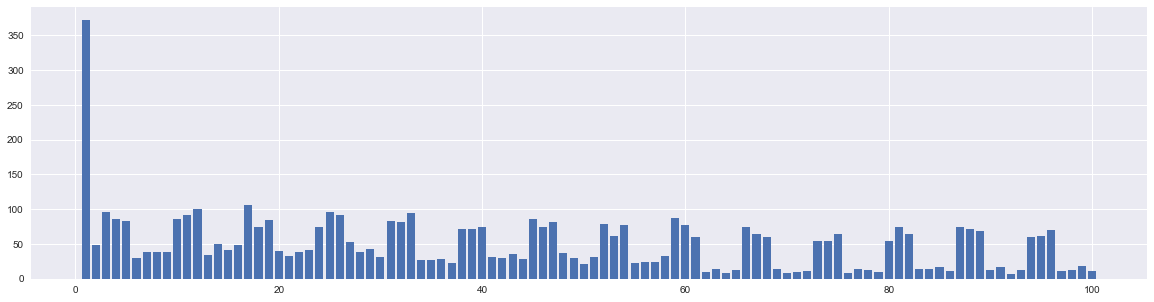

In [437]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(data.groupby('choice_0')['choice_0'].count().index,data.groupby('choice_0')['choice_0'].count().values)

## The majority of choice_1 are for dates before the choice_0, due to the majority of choice_0 being the last day, Christmas Eve

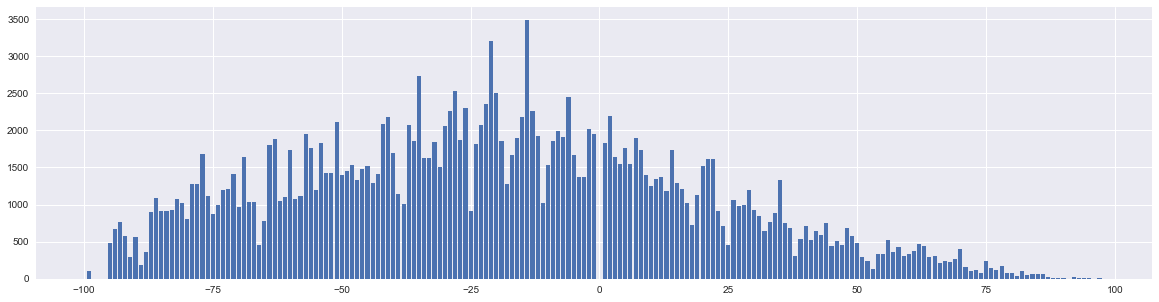

In [438]:
plt.close('all')
plt.style.use('seaborn')


fig, ax = plt.subplots(figsize=(20,5))

bar = ax.bar(data.groupby((data['choice_1'] - data['choice_0'])).agg('sum',axis="columns")['choice_0'].index,\
       data.groupby((data['choice_1'] - data['choice_0'])).agg('sum',axis="columns")['choice_0'])

In [439]:
# Creating column with day of week for choice_0
date_dict = date_index.day.to_dict()
data['choice_0_day']= data['choice_0'].map(date_dict)

## Most preferences are for Friday, Saturday, Sunday. Tuesday is Christmas Eve

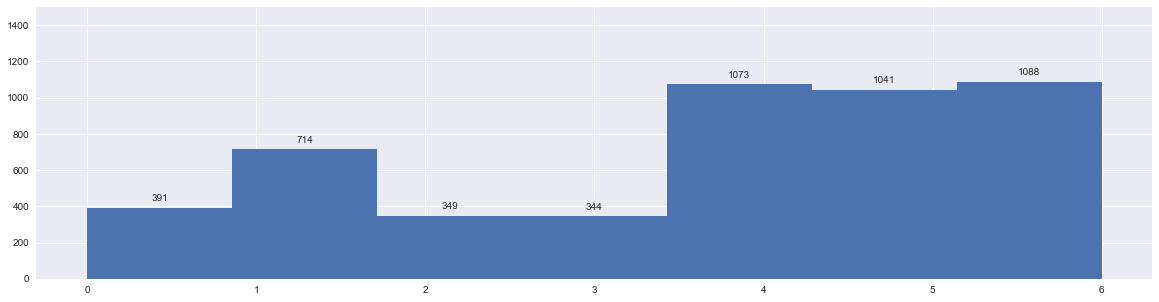

In [440]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

hist = ax.hist(data['choice_0_day'].astype('int'),bins=7)
ax.set(ylim=(0,1500))

add_value_labels(ax)

In [441]:
# Reset occupancy
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=date_index.index,columns=columns)

occupancy.head()

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0


## Creating Daily Limits Function

In [829]:
def daily_limit(choice,n_people,pref,remaining):

    min_choice = occupancy['total'].idxmin() #for any unassigned families, put them in smallest bucket
    
    # Looping through all family choices until finding match and ensuring buckets get filled to 150 at least
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref < 9:
        if remaining > occupancy[occupancy['total'] < 125]['total'].sum() + n_people:
            if occupancy.loc[choice]['total'] < 225: # Can add people to bucket with less than the min
                occupancy.loc[choice]['pref_{}'.format(pref)] += n_people
                occupancy.loc[choice]['total'] += n_people
                return 1 #Should stop iterating when adding to occupancy df
            else:
                return 0
        else:
            return 0 #Should continue iterating through choices when buckets need to be filled
        
    if occupancy.loc[choice]['total'] + n_people <= 300 and pref == 9:
        occupancy.loc[min_choice]['pref_10'] += n_people # this needs to be updated to account for actual preference when its the same (or maybe top 10 buckets?)
        occupancy.loc[min_choice]['total'] += n_people
        return 2
    
    else:
        return 0 #Should continue iterating through choices

## New loop with additional daily limit function added

In [830]:
# Testing logic for dynamically looking at choices
j = 0

# Reset occupancy dataframe
columns = ['pref_0', 'pref_1', 'pref_2', 'pref_3', 'pref_4', 'pref_5',
       'pref_6', 'pref_7', 'pref_8', 'pref_9','pref_10','total']
occupancy = pd.DataFrame(0,index=date_index.index,columns=columns)

# Create submission dataframe
submission = pd.DataFrame(data,columns=['assigned_day','pref'])

remaining = 20968 # total number of people

for index,row in data.iterrows():
    for i in range(10):
        choice = row['choice_{}'.format(i)]
        n_people = row['n_people']
        family_id = index
        
        # Runs occupancy filling function from highlest to lowest preference
        add_check = daily_limit(choice,n_people,i,remaining)
        
        if add_check == 1:
            remaining -= n_people # Removing added people
            submission.iloc[family_id] = choice.astype('int')
            submission.iloc[family_id]['pref'] = i
            break
        if add_check == 2:
            remaining -= n_people # Removing added people
            min_choice = occupancy['total'].idxmin() # for any unassigned families, put them in smallest bucket
            submission.iloc[family_id]['assigned_day'] = min_choice
            submission.iloc[family_id]['pref'] = 10
            break
        if add_check == 0:
            pass
        else:
            assert False, 'Error with add_check'

## The chart below shows that way too many people are getting either their first or last choice

In [831]:
def top_pref_penalty(pref,d):
    
    penalty = 0
    n = pref
    
    d = d
    if pref > 0:
        if d == 0:
            penalty += 0
        elif d == 1:
            penalty += 50
        elif d == 2:
            penalty += 50 + 9 * n
        elif d == 3:
            penalty += 100 + 9 * n
        elif d == 4:
            penalty += 200 + 9 * n
        elif d == 5:
            penalty += 200 + 18 * n
        elif d == 6:
            penalty += 300 + 18 * n
        elif d == 7:
            penalty += 300 + 36 * n
        elif d == 8:
            penalty += 400 + 36 * n
        elif d == 9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    else:
        pass
        
    return penalty

## Looking at how cost changes based on preference, ensuring people do not get choice 9 or no choice is ideal to keep costs down

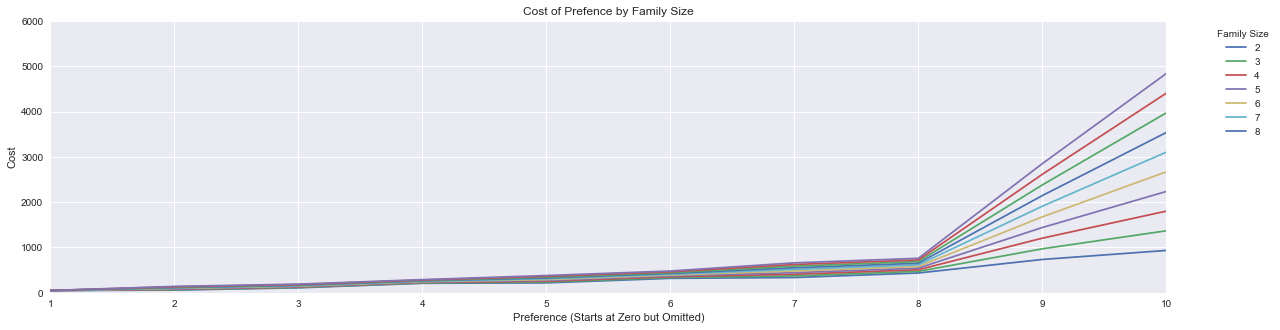

In [832]:
# Setting average family size
fam_size = sorted(list(data['n_people'].unique()))
pref = range(1,11)

# Labels for stacked plot
labels = fam_size

pref_0 = [top_pref_penalty(0,d) for d in pref]
pref_1 = [top_pref_penalty(1,d) for d in pref]
pref_2 = [top_pref_penalty(2,d) for d in pref]
pref_3 = [top_pref_penalty(3,d) for d in pref]
pref_4 = [top_pref_penalty(4,d) for d in pref]
pref_5 = [top_pref_penalty(5,d) for d in pref]
pref_6 = [top_pref_penalty(6,d) for d in pref]
pref_7 = [top_pref_penalty(7,d) for d in pref]
pref_8 = [top_pref_penalty(8,d) for d in pref]
pref_9 = [top_pref_penalty(9,d) for d in pref]
pref_10 = [top_pref_penalty(10,d) for d in pref]


# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Preference (Starts at Zero but Omitted)')
ax.set_ylabel('Cost')
ax.set_ylim(0,6000)
ax.set_xlim(1,10)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pref,pref_1)
ax2 = ax.plot(pref,pref_2)
ax3 = ax.plot(pref,pref_3)
ax4 = ax.plot(pref,pref_4)
ax5 = ax.plot(pref,pref_5)
ax6 = ax.plot(pref,pref_6)
ax7 = ax.plot(pref,pref_7)
ax8 = ax.plot(pref,pref_8)
ax9 = ax.plot(pref,pref_9)
ax10 = ax.plot(pref,pref_10)

ax.legend(labels=labels,loc=1,bbox_to_anchor=(1.1, 1),title='Family Size')
ax.set_title('Cost of Prefence by Family Size')

plt.show()

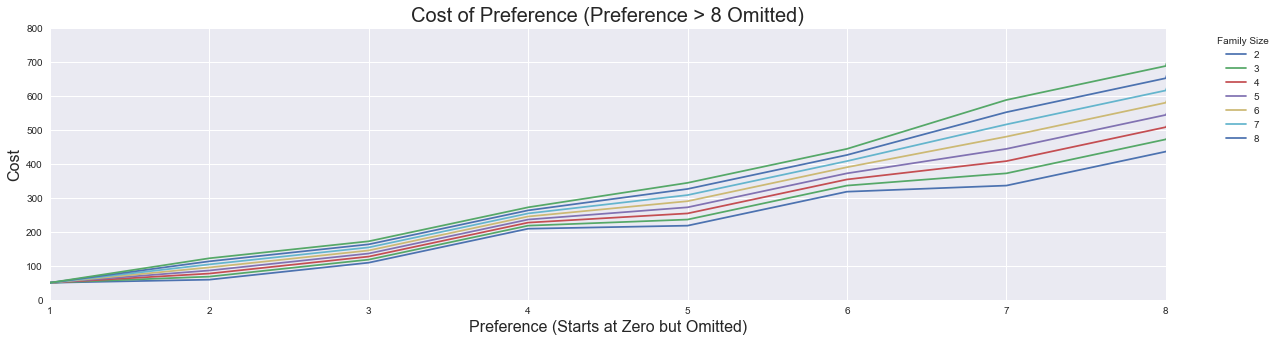

In [833]:
# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Preference (Starts at Zero but Omitted)',fontsize=16)
ax.set_ylabel('Cost',fontsize=16)
ax.set_ylim(0,800)
ax.set_xlim(1,8)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pref,pref_1)
ax2 = ax.plot(pref,pref_2)
ax3 = ax.plot(pref,pref_3)
ax4 = ax.plot(pref,pref_4)
ax5 = ax.plot(pref,pref_5)
ax6 = ax.plot(pref,pref_6)
ax7 = ax.plot(pref,pref_7)
ax8 = ax.plot(pref,pref_8)

ax.legend(labels=labels,loc=1,bbox_to_anchor=(1.1, 1),title='Family Size')
ax.set_title('Cost of Preference (Preference > 8 Omitted)',fontsize=20)

plt.show()

In [834]:
occupancy['pref_pen'] = 0

# Applies preference penalty across all preference columns (pref_#) and sums to one column
for i in range(11):
    occupancy['pref_pen'] += occupancy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)

In [835]:
occupancy.head(10)

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen
1,227,0,0,0,0,0,0,0,0,0,0,227,0
2,170,14,12,5,7,14,0,4,0,0,0,226,1512
3,224,6,0,0,0,0,0,0,0,0,0,230,50
4,207,16,0,0,0,3,0,0,0,0,0,226,304
5,206,16,4,0,0,0,0,0,0,0,0,226,136
6,111,34,13,36,18,10,0,0,3,0,0,225,1891
7,150,30,21,10,4,7,0,0,5,0,0,227,1621
8,139,30,23,7,4,13,7,0,4,0,0,227,2110
9,144,25,26,9,10,5,0,0,6,0,0,225,1711
10,217,9,0,0,0,0,0,0,0,0,0,226,50


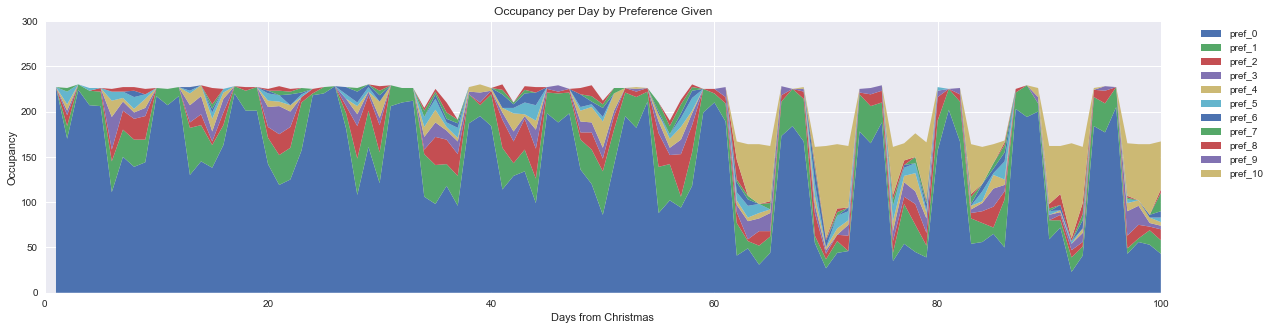

In [836]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(occupancy.columns)[:11]

# Creating individual lists for each preference (required for stacked plot)
pref_0 = list(occupancy['pref_0'].values)
pref_1 = list(occupancy['pref_1'].values)
pref_2 = list(occupancy['pref_2'].values)
pref_3 = list(occupancy['pref_3'].values)
pref_4 = list(occupancy['pref_4'].values)
pref_5 = list(occupancy['pref_5'].values)
pref_6 = list(occupancy['pref_6'].values)
pref_7 = list(occupancy['pref_7'].values)
pref_8 = list(occupancy['pref_8'].values)
pref_9 = list(occupancy['pref_9'].values)
pref_10 = list(occupancy['pref_10'].values)

# Getting days from Occupancy dataframe
x = list(occupancy.index.values)

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,300)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))
ax.set_title('Occupancy per Day by Preference Given')

plt.show()

## Accounting cost for all days
#### Accounting costs grow exponentially when the gap between daily volumes is large

In [844]:
days

[100,
 99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

In [845]:
occupancy['acct_cost'] = 0
days = list(range(1,101,1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['total']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:

    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0., (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occupancy.head(20)

,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,total,pref_pen,acct_cost,total_cost
1,227,0,0,0,0,0,0,0,0,0,0,227,0,3,4
2,170,14,12,5,7,14,0,4,0,0,0,226,1512,4,1517
3,224,6,0,0,0,0,0,0,0,0,0,230,50,6,56
4,207,16,0,0,0,3,0,0,0,0,0,226,304,5,307
5,206,16,4,0,0,0,0,0,0,0,0,226,136,3,140
6,111,34,13,36,18,10,0,0,3,0,0,225,1891,4,1895
7,150,30,21,10,4,7,0,0,5,0,0,227,1621,4,1624
8,139,30,23,7,4,13,7,0,4,0,0,227,2110,3,2114
9,144,25,26,9,10,5,0,0,6,0,0,225,1711,4,1715
10,217,9,0,0,0,0,0,0,0,0,0,226,50,4,54


## From the plot below, Accounting Cost rises exponentially as the daily delta rises

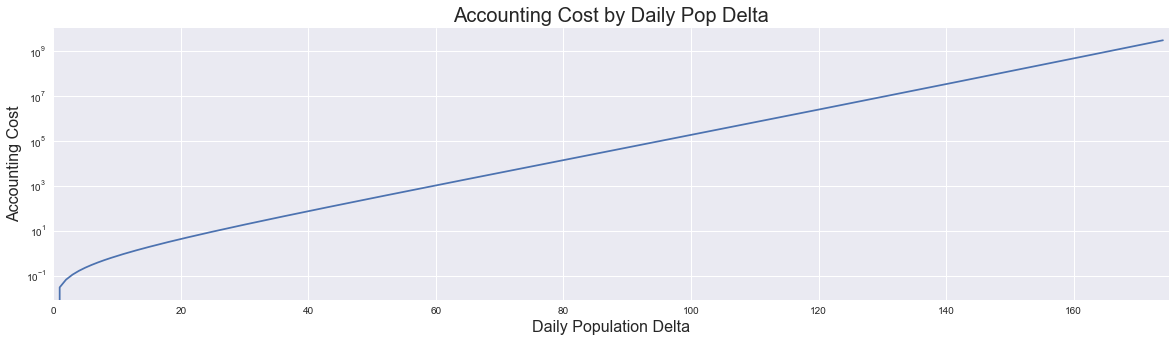

In [846]:
pop_range = range(125,300)

cost = [max(0, (x-125.0) / 400.0 * x**(0.5 + (x-125) / 50.0)) for x in pop_range]
        
pop_delta = range(0,175)

# Setting figure
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Daily Population Delta',fontsize=16)
ax.set_ylabel('Accounting Cost',fontsize=16)
# ax.set_ylim(0,800)
ax.set_yscale('log')
ax.set_xlim(0,175)

# Creating plot
# ax0 = ax.plot(pref,pref_0)
ax1 = ax.plot(pop_delta,cost)

ax.set_title('Accounting Cost by Daily Pop Delta',fontsize=20)

plt.show()

In [847]:
# First day accounting cost
np.round(max(0,(300-125.0) / 400.0 * 300**(0.5)),2)

7.58

In [848]:
occupancy['total_cost'] = occupancy['pref_pen'] + occupancy['acct_cost']
score = occupancy['total_cost'].sum()
submission['assigned_day'] = submission['assigned_day'].astype('str')

submission[['assigned_day']].to_csv(f'submission_{score}.csv')
print('{0:,}'.format(score))

710,757


In [677]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4,6
1,26,4,82,5,11,47,38,6,66,61,4,4
2,100,54,25,12,27,82,10,89,80,33,3,0
3,2,95,1,96,32,6,40,31,9,59,2,0
4,53,1,47,93,26,3,46,16,42,39,4,5


In [631]:
# Creating occupancy delta dataframe to add limits for changes
occupancy_count = pd.DataFrame(0, index=range(1,101), columns=['delta'])
occ_copy = occupancy.copy(deep=True)
occupancy_small

# Creating copy of submission to compare results
submission2 = submission.copy(deep=True)

# Creating smaller submission dataframe to try to re-arrange requests with preference greater 7
submission_small = submission[submission.pref > 7].sort_values(by=['pref','assigned_day'],ascending=[False,True])

for index,row in submission_small.iterrows():
    for i in range(1,9):
#         occupancy_small = occ_copy['total'] # needs to reset after every check
        n_people = data.iloc[index]['n_people']
        family_id = index
        
        new_pref = i # Preference of current i in loop
        current_pref = row['pref'].astype('int') # Current preference for current assigned day
        
        new_day = data.iloc[index]['choice_{}'.format(i)].astype('int') # Find preferred day by choice in data dataframe
        current_day = row['assigned_day'].astype('int') # Current assigned day in submission_small dataframe
        
        
#         print('Current Day: {}, Current Pref: {}, New Day: {}, , New Pref: {}, Family_id: {}, n_people: {}'\
#               .format(current_day,current_pref,new_day,new_pref,family_id,n_people))
        
#         try:
        
        if (occupancy_small.loc[current_day] - n_people >= 125) &\
            (occupancy_small.loc[new_day] + n_people <= 300) &\
            list(abs(occupancy_count.loc[new_day]).values)[0] < 20&\
            list(abs(occupancy_count.loc[current_day]).values)[0] < 20:
            
            print(True)

            occ_copy.loc[new_day]['pref_{}'.format(i)] += n_people
            occ_copy.loc[new_day]['total'] += n_people

            occ_copy.loc[current_day]['pref_{}'.format(current_pref)] -= n_people
            occ_copy.loc[current_day]['total'] -= n_people

            submission2.loc[family_id]['assigned_day'] = new_day
            submission2.loc[family_id]['pref'] = new_pref

            occupancy_count.loc[new_day]['delta'] += n_people
            occupancy_count.loc[current_day]['delta'] -= n_people

            break

        else:
            pass
        
#         except:
#             print('Current Day: {}, Current Pref: {}, New Day: {}, , New Pref: {}, Family_id: {}, n_people: {}'\
#               .format(current_day,current_pref,new_day,new_pref,family_id,n_people))
            

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [570]:
occupancy_small = occupancy['total']
occupancy_small

1      210
2      208
3      212
4      212
5      209
      ... 
96     208
97     211
98     210
99     208
100    208
Name: total, Length: 100, dtype: int64

In [587]:
data.loc[1]['n_people']

4

In [629]:
occupancy_count.loc[1]['delta'].astype('int')

0

In [630]:
# Creating occupancy delta dataframe to add limits for changes
occupancy_count = pd.DataFrame(0, index=range(1,101), columns=['delta'])
occ_copy = occupancy.copy(deep=True)
occupancy_small = occupancy[['total']]

# Creating copy of submission to compare results
submission2 = submission.copy(deep=True)

# Creating smaller submission dataframe to try to re-arrange requests with preference greater 7
submission_small = submission[submission.pref > 7].sort_values(by=['pref','assigned_day'],ascending=[False,True])

for index,row in submission_small.iterrows():
    for i in range(1,9):
#         occupancy_small = occ_copy['total'] # needs to reset after every check
        n_people = data.loc[index]['n_people']
        family_id = index
        
        new_pref = i # Preference of current i in loop
        current_pref = row['pref'].astype('int') # Current preference for current assigned day
        
        new_day = data.loc[index]['choice_{}'.format(i)].astype('int') # Find preferred day by choice in data dataframe
        current_day = row['assigned_day'].astype('int') # Current assigned day in submission_small dataframe
        
        
#         try:
        
        if (occupancy_small.loc[current_day] - n_people >= 125) &\
            (occupancy_small.loc[new_day] + n_people <= 300) &\
            (abs(occupancy_count.loc[new_day]['delta']) <= 20)&\
            (abs(occupancy_count.loc[current_day]['delta']) <= 20):

#                 print(True)

            occupancy_count.loc[new_day]['delta'] += n_people
            occupancy_count.loc[current_day]['delta'] -= n_people

            break

        else:
#                 print('first: {}, second: {}, third: {}, fourth: {}'\
#                       .format((occupancy_small.iloc[current_day] - n_people),\
#                              (occupancy_small.iloc[new_day] + n_people),\
#                              (list(abs(occupancy_count.iloc[new_day]).values)[0]),\
#                              (list(abs(occupancy_count.iloc[current_day]).values)[0])
#                              ))
            pass

#         except:
#             print('Current Day: {}, Current Pref: {}, New Day: {}, , New Pref: {}, Family_id: {}, n_people: {}'\
#               .format(current_day,current_pref,new_day,new_pref,family_id,n_people))
        

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [585]:
occupancy_count

,delta
1,339
2,-13
3,39
4,93
5,87
...,...
96,23
97,-97
98,-88
99,-101


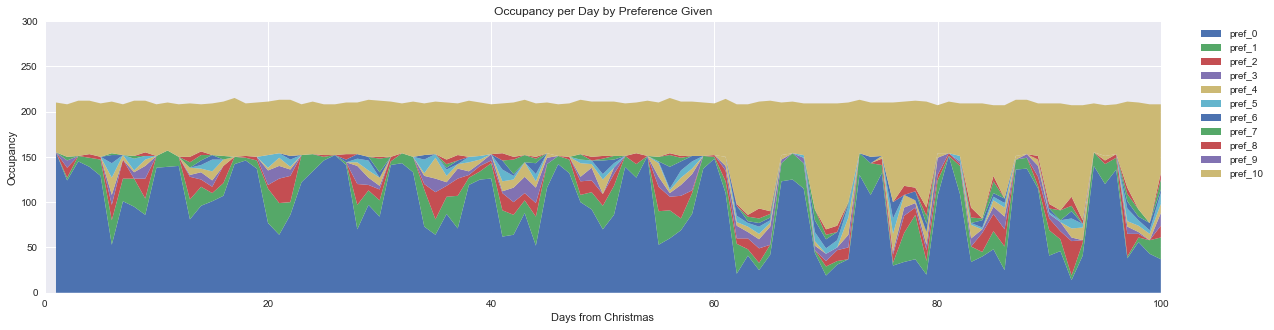

In [547]:
plt.close('all')
plt.style.use('seaborn')

# Labels for stacked plot
labels = list(occ_copy.columns)[:11]

# Creating individual lists for each preference (required for stacked plot)
pref_0 = list(occ_copy['pref_0'].values)
pref_1 = list(occ_copy['pref_1'].values)
pref_2 = list(occ_copy['pref_2'].values)
pref_3 = list(occ_copy['pref_3'].values)
pref_4 = list(occ_copy['pref_4'].values)
pref_5 = list(occ_copy['pref_5'].values)
pref_6 = list(occ_copy['pref_6'].values)
pref_7 = list(occ_copy['pref_7'].values)
pref_8 = list(occ_copy['pref_8'].values)
pref_9 = list(occ_copy['pref_9'].values)
pref_10 = list(occ_copy['pref_10'].values)

# Getting days from Occupancy dataframe
x = list(occ_copy.index.values)

# Setting figure
fig, ax = plt.subplots(figsize=(20,5))

# Formatting plot area
ax.set_xlabel('Days from Christmas')
ax.set_ylabel('Occupancy')
ax.set_ylim(0,300)
ax.set_xlim(0,100)

# Creating plot
ax.stackplot(x,pref_0,pref_1,pref_2,pref_3,pref_4,pref_5,pref_6,pref_7,pref_8,pref_9,pref_10,labels=labels)
ax.legend(loc=1,bbox_to_anchor=(1.1, 1))
ax.set_title('Occupancy per Day by Preference Given')

plt.show()

In [540]:
occupancy_count[occupancy_count['delta'] > 0]

,delta


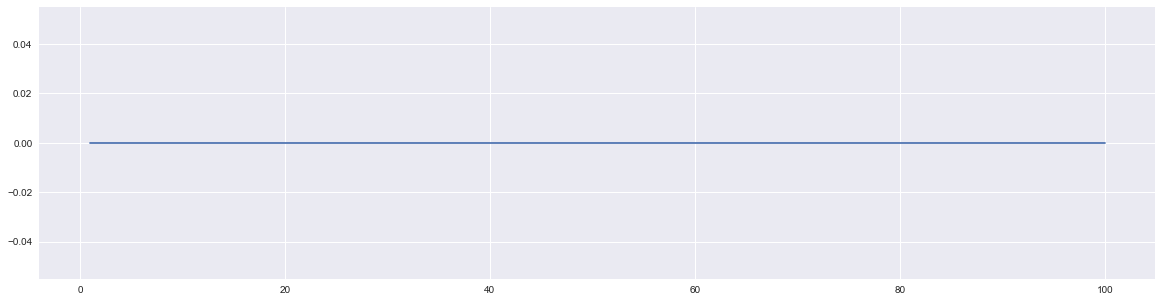

In [525]:
plt.close('all')
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(20,5))

ax = ax.plot(occupancy_count.index,occupancy_count['delta'])

In [524]:
# Re-calculate preference penalty
occupancy['pref_pen'] = 0

# Applies preference penalty across all preference columns (pref_#) and sums to one column
for i in range(11):
    occupancy['pref_pen'] += occupancy.apply(lambda x: top_pref_penalty(x['pref_{}'.format(i)],i),axis=1)
    
# Re-calculate accounting penalty
occupancy['acct_cost'] = 0
days = list(range(100,0,-1))

# First day is special
occupancy.loc[days[0]]['acct_cost'] = (occupancy.loc[days[0]]['total']-125.0) / 400.0 *\
                                       occupancy.loc[days[0]]['total']**(0.5)

# Loop over the rest of the days, keeping track of previous count
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:
    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0, (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

occupancy['total_cost'] = occupancy['pref_pen'] + occupancy['acct_cost']
score = occupancy['total_cost'].sum()

submission.to_csv(f'submission_{score}.csv')
print('{0:,}'.format(score))

3,256,874


In [310]:

for index,row in submission_small.iterrows():
    for i in range(8):
        occupancy_small = occupancy['total']
        current_pref = row['pref']
        new_pref = data.iloc[index]['choice_{}'.format(i)]
        n_people = data.iloc[index]['n_people']
        family_id = index
        current_day = row['assigned_day']
        
        if current_day == 1:
            current_acct = 
            
        else:
            diff = abs(occupancy_small.iloc[current_day] - occupancy_small.iloc[current_day])
            
            current_acct = max(0, (occupancy_small.iloc[current_day]+n_people-125.0) / 400.0 *\
                               occupancy_small.iloc[current_day]**(0.5 + diff / 50.0))
        
        
        current_diff = occupancy_small.iloc[current] - occupancy_small.iloc[current-1]
        
    if (choice < current) & \
        
        
        
        # Passes lower limit on old bukcet
        # Passes upper limit on new bucket
        occupancy.loc[day]['acct_cost'] = max(0, (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
        # Will need update for day 1
        
        
        
yesterday_count = occupancy.loc[days[0]]['total']
for day in days[1:]:
    today_count = occupancy.loc[day]['total']
    diff = abs(today_count - yesterday_count)
    occupancy.loc[day]['acct_cost'] = max(0, (occupancy.loc[day]['total']-125.0) / 400.0 *\
                                              occupancy.loc[day]['total']**(0.5 + diff / 50.0))
    yesterday_count = today_count

72.0
70.0
9.0
89.0
92.0
76.0
79.0
64.0
79.0
27.0
14.0
70.0
83.0
79.0
83.0
92.0
83.0
70.0
84.0
44.0
64.0
83.0
13.0
84.0
92.0
100.0
70.0
63.0
79.0
62.0
92.0
64.0
63.0
84.0
93.0
65.0
99.0
76.0
63.0
99.0
42.0
65.0
93.0
63.0
64.0
83.0
91.0
30.0
92.0
70.0
76.0
13.0
99.0
77.0
92.0
93.0
65.0
76.0
78.0
63.0
65.0
71.0
37.0
85.0
49.0
76.0
93.0
98.0
69.0
99.0
63.0
64.0
65.0
71.0
91.0
79.0
85.0
90.0
92.0
76.0
41.0
65.0
77.0
97.0
63.0
70.0
79.0
90.0
91.0
83.0
91.0
97.0
63.0
76.0
84.0
62.0
71.0
83.0
90.0
98.0
79.0
99.0
65.0
98.0
62.0
70.0
99.0
64.0
71.0
72.0
90.0
98.0
99.0
63.0
72.0
79.0
62.0
70.0
57.0
62.0
86.0
83.0
84.0
64.0
70.0
85.0
93.0
98.0
86.0
65.0
85.0
62.0
70.0
86.0
92.0
72.0
79.0
83.0
90.0
93.0
62.0
71.0
83.0
63.0
69.0
92.0
70.0
84.0
97.0
98.0
99.0
76.0
62.0
72.0
50.0
79.0
84.0
63.0
65.0
71.0
90.0
99.0
64.0
79.0
69.0
76.0
84.0
72.0
65.0
71.0
69.0
76.0
86.0
98.0
71.0
72.0
76.0
93.0
70.0
83.0
91.0
90.0
99.0
36.0
64.0
71.0
92.0
62.0
72.0
97.0
85.0
99.0
71.0
78.0
83.0
86.0
69.0
72.0
98.0
62.0


## Draft solution for optimization using a new dataframe

In [304]:
intermediate = submission.merge(data, left_index = True,right_index=True,how='left')
intermediate.head()

,assigned_day,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,,
0,52.0,52,38,12,82,33,75,64,76,10,28,4,6
1,26.0,26,4,82,5,11,47,38,6,66,61,4,4
2,100.0,100,54,25,12,27,82,10,89,80,33,3,0
3,2.0,2,95,1,96,32,6,40,31,9,59,2,0
4,53.0,53,1,47,93,26,3,46,16,42,39,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,70.0,16,1,66,33,18,70,56,46,86,60,4,0
4996,73.0,88,66,20,17,26,54,81,91,59,48,2,5
4997,78.0,32,66,54,17,27,21,74,81,3,7,6,5


In [311]:
intermediate2 = intermediate.where((intermediate['assigned_day'] != intermediate['choice_0']) &
                  (intermediate['assigned_day'] != intermediate['choice_1']) &
                  (intermediate['assigned_day'] != intermediate['choice_2']) &                  
                  (intermediate['assigned_day'] != intermediate['choice_3']) &                 
                  (intermediate['assigned_day'] != intermediate['choice_4']) &                  
                  (intermediate['assigned_day'] != intermediate['choice_5']) &                  
                  (intermediate['assigned_day'] != intermediate['choice_6']) &                 
                  (intermediate['assigned_day'] != intermediate['choice_7'])).dropna()\
[['assigned_day','choice_0','choice_1','choice_2','choice_3','choice_4','choice_5','choice_6','choice_7','n_people']]

intermediate2.head()

,assigned_day,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,n_people
family_id,,,,,,,,,,
2228,72.0,47.0,1.0,54.0,67.0,94.0,18.0,25.0,95.0,5.0
2387,70.0,80.0,59.0,46.0,12.0,52.0,88.0,82.0,1.0,6.0
2403,9.0,46.0,96.0,73.0,1.0,88.0,4.0,81.0,45.0,4.0
2411,89.0,1.0,96.0,80.0,12.0,10.0,19.0,3.0,26.0,4.0
2414,92.0,39.0,94.0,3.0,1.0,73.0,54.0,5.0,23.0,4.0


# Code from starter book

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [46]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [42]:
def cost_function(prediction):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}

    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

## Simple Opimization Approach

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [43]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

Score: 736542.7844967854


# Scrap

In [39]:
# Creating my empty occupancy dataframe for controlling limits
occupancy = pd.DataFrame(0,index=date_index.index,columns=['occ_count'])
occupancy

,occ_count
1,0
2,0
3,0
4,0
5,0
...,...
96,0
97,0
98,0
99,0


In [40]:
# Creating trimmed dataframe of non-peak requests (Mon-Thur) and non-Xmas Eve
non_weekend_or_xmas = data.where(~data.choice_0_day.isin([4,5,6])&data.choice_0_day != 1).dropna()
non_weekend_or_xmas.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,choice_0_day
family_id,,,,,,,,,,,,
0,52.0,38.0,12.0,82.0,33.0,75.0,64.0,76.0,10.0,28.0,4.0,6.0
1,26.0,4.0,82.0,5.0,11.0,47.0,38.0,6.0,66.0,61.0,4.0,4.0
2,100.0,54.0,25.0,12.0,27.0,82.0,10.0,89.0,80.0,33.0,3.0,0.0
3,2.0,95.0,1.0,96.0,32.0,6.0,40.0,31.0,9.0,59.0,2.0,0.0
4,53.0,1.0,47.0,93.0,26.0,3.0,46.0,16.0,42.0,39.0,4.0,5.0


In [41]:
# Adding non-peak requests to occupancy dataframe
for index,row in non_weekend_or_xmas.iterrows():
    occupancy['occ_count'][row['choice_0']] += row['n_people']
#     print(index,row['n_people'])

In [18]:
# loops = 100
# for i in range(100):
#     data['picked_choice_{}'.format(i)] = 10
#     data['picked_day_{}'.format(i)] = -2
    